# Literary Analysis: Comparing Nonfiction and Fiction through Topic Modeling and Sentiment Analysis 

### ADS 509 Final Project
##### Team 3: Claire Bentzen, Tara Dehdari, Logan Van Dine

##### Introduction

In this project, we will conduct a comparative analysis of numerous significant literary works representing both fiction an nonfiction genres. The texts engage deeply with themes of gender, society, and individual rights, making them ideal for exploring the differences in language, themes, and sentiment between fiction and nonfiction.

Using text mining techniques, we will analyze how each genre approaches these themes, examining the stylistic and rhetorical differences that characterize fiction versus nonfiction. Our analysis will involve data cleaning, tokenization, and the application of descriptive statistics, sentiment analysis, and topic modeling. By comparing these works, we aim to uncover the unique ways in which each genre communicates similar ideas, providing insights into the broader distinctions between fiction and nonfiction writing.


### Imports

In [1]:
import requests
import os
import re
import pandas as pd
import numpy as np
import nltk
import warnings


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from bs4 import BeautifulSoup  
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from string import punctuation
from collections import Counter, defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\lvand\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Scraping

This portion scrapes and saves the full text of Pride and Prejudice and A Vindication of the Rights of Woman from Project Gutenberg. It ensures the save directory exists, extracts text from the HTML, saves it to .txt files, and verifies that the files were created successfully, showing a preview of the content.

In [2]:
# Define the URLs for the books
## fiction
url_pride_prej = 'https://www.gutenberg.org/cache/epub/1342/pg1342-images.html'
url_awakening = 'https://www.gutenberg.org/cache/epub/160/pg160-images.html'
url_north_south = 'https://www.gutenberg.org/cache/epub/4276/pg4276-images.html'
url_wuthering_heights = 'https://www.gutenberg.org/cache/epub/768/pg768-images.html'
## nonfiction
url_vin_of_women = 'https://www.gutenberg.org/cache/epub/3420/pg3420-images.html'
url_enfranchisement = 'https://www.gutenberg.org/cache/epub/73404/pg73404-images.html'
url_on_liberty = 'https://www.gutenberg.org/cache/epub/34901/pg34901-images.html'
url_subjection_women = 'https://www.gutenberg.org/cache/epub/27083/pg27083-images.html'

# Define the directory to save the files
data_dir = './data'

# Ensure the directory exists
os.makedirs(data_dir, exist_ok=True)

# Function to scrape and save books
def scrape_and_save_book(url, file_name):
    # Send a GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Check that the request was successful
    
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract all text from <p> tags
    paragraphs = soup.find_all(['p', 'h1', 'h2', 'h3'])
    book_text = '\n'.join([para.get_text() for para in paragraphs if para.get_text().strip()])

    
    # Save the extracted text to a file
    file_path = os.path.join(data_dir, file_name)
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(book_text)
    
    print(f"Text from '{file_name}' scraped and saved.")
    
    # Check if the file is saved and contains content
    if os.path.exists(file_path):
        print(f"File '{file_path}' has been created successfully.")
        # Check the first few lines of the file
        with open(file_path, 'r', encoding='utf-8') as file:
            preview = file.read(100)  # Read the first 100 characters
            print("File content preview:\n")
            print(preview)
    else:
        print(f"Failed to create the file '{file_path}'.")

# List of Fiction book tuples
fiction_books = [
    (url_pride_prej, 'pride_and_prejudice.txt'),
    (url_awakening, 'the_awakening.txt'),
    (url_north_south, 'north_and_south.txt'),
    (url_wuthering_heights, 'wuthering_heights.txt')
]

# Loop over the list and scrape/save each book
for url, filename in fiction_books:
    scrape_and_save_book(url, filename)

# List of Nonfiction book tuples
nonfiction_books = [
    (url_vin_of_women, 'vindication_of_rights_of_woman.txt'),
    (url_enfranchisement, 'the_enfranchisement_of_women.txt'),
    (url_on_liberty, 'on_liberty.txt'),
    (url_subjection_women, 'the_subjection_of_women.txt')
]

# Loop over the list and scrape/save each book
for url, filename in nonfiction_books:
    scrape_and_save_book(url, filename)

Text from 'pride_and_prejudice.txt' scraped and saved.
File './data\pride_and_prejudice.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of Pride and Prejudice
Title: Pride and Prejudice
Author: Jane Austen
Re
Text from 'the_awakening.txt' scraped and saved.
File './data\the_awakening.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of The Awakening, and Selected Short Stories
Title: The Awakening, and S
Text from 'north_and_south.txt' scraped and saved.
File './data\north_and_south.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of North and South
Title: North and South
Author: Elizabeth Cleghorn Gas
Text from 'wuthering_heights.txt' scraped and saved.
File './data\wuthering_heights.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of Wuthering Heights
Title: Wuthering Heights
Author: Emily Brontë
Relea
Text from 'vindication_of_rights

### Data Cleaning and Tokenization

This section converts the raw text into a dataframe format that includes information about the books.

In [3]:
# Initialize empty dataframe
books = pd.DataFrame(columns=['Title', 'Author', 'Release_Date', 'Updated_Date', 'Language', 'Credits', 'Text', 'Genre'])

# Function to convert text to DataFrame
def convert_to_df(file_name, genre):
    # Establish file path
    file_path = os.path.join(data_dir, file_name)
    
    # Open contents of file
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            
            # Extract relevant sections with error handling for missing fields
            title = re.search(r'Title:\s*(.*)', content)
            title = title.group(1) if title else 'Unknown'
            
            author = re.search(r'Author:\s*(.*)', content)
            author = author.group(1) if author else 'Unknown'
            
            release_date = re.search(r'Release date:\s*(.*)\[eBook', content)
            release_date = release_date.group(1).strip() if release_date else 'Unknown'
            
            updated_date = re.search(r'Most recently updated:\s*(.*)', content)
            updated_date = updated_date.group(1) if updated_date else 'Not available'
            
            language = re.search(r'Language:\s*(.*)', content)
            language = language.group(1) if language else 'Unknown'
            
            credits = re.search(r'Credits:\s*(.*)', content)
            credits = credits.group(1) if credits else 'Not available'
            
            # Extract book text
            match = re.search(r'Credits:.*?\n(.*)', content, re.DOTALL)
            book_text = match.group(1).strip() if match else 'No text available'
            
            # Dictionary for book information
            book_info = {
                'Title': title,
                'Author': author,
                'Release_Date': release_date,
                'Updated_Date': updated_date,
                'Language': language,
                'Credits': credits,
                'Text': book_text,
                'Genre': genre  
            }
            
            # Add data to books DataFrame
            books.loc[len(books)] = book_info
            
    else:
        print(f"The file '{file_name}' does not exist.")



##### Call on Dataframe Function with both texts

In [4]:
# Create list/loop to call on dataframe function
# Combined list of  tuples for both Fiction and Nonfiction
books_list = [
    ('pride_and_prejudice.txt', 'Fiction'),
    ('the_awakening.txt', 'Fiction'),
    ('north_and_south.txt', 'Fiction'),
    ('wuthering_heights.txt', 'Fiction'),
    ('vindication_of_rights_of_woman.txt', 'Nonfiction'),
    ('the_enfranchisement_of_women.txt', 'Nonfiction'),
    ('on_liberty.txt', 'Nonfiction'),
    ('the_subjection_of_women.txt', 'Nonfiction')
]

# Loop over the combined list and convert to DataFrame
for filename, genre in books_list:
    convert_to_df(filename, genre)

In [5]:
# Display the books DataFrame to check the loaded texts
books.head()

,Title,Author,Release_Date,Updated_Date,Language,Credits,Text,Genre
0,Pride and Prejudice,Jane Austen,"June 1, 1998","June 17, 2024",English,Chuck Greif and the Online Distributed Proofre...,"PREFACE.\nList of Illustrations.\nChapter: I.,...",Fiction
1,"The Awakening, and Selected Short Stories",Kate Chopin,"March 11, 2006","February 28, 2021",English,Judith Boss and David Widger,The Awakeningand Selected Short Stories\nby Ka...,Fiction
2,North and South,Elizabeth Cleghorn Gaskell,"July 1, 2003","February 8, 2024",English,Produced by Chuck Greif and the Online Distrib...,NORTH AND SOUTH.\n“SHE LAY CURLED UPON THE SOF...,Fiction
3,Wuthering Heights,Emily Brontë,"December 1, 1996","January 18, 2022",English,David Price,Wuthering Heights\nby Emily Brontë\nCHAPTER I\...,Fiction
4,A Vindication of the Rights of Woman,Mary Wollstonecraft,"September 1, 2002","January 8, 2021",English,"This etext was produced by Amy E Zelmer, Col C...",This etext was produced by\nAmy E Zelmer <a.z...,Nonfiction


This section cleans and tokenizes the Text column with the following steps:
1. Cast to lowercase
2. Remove punctuation
3. Tokenize
4. Remove stopwords

In [6]:
# Punctuation
punctuation = set(punctuation) 

# Removes punctuation
def remove_punctuation(text, punct_set=punctuation): 
    
    return("".join([ch for ch in text if ch not in punct_set]))

# Stopwords
sw = stopwords.words("english")

# Removes stopwords
def remove_stop(tokens):
    
    tokens = [word for word in tokens if word not in sw]
    
    return(tokens)
 

# Tokenize the text
def tokenize(text):     
    
    return text.split()

# Applies the pipeline
def pipeline(text): 
    
    text = str.lower(text)
    text = remove_punctuation(text)
    tokens = tokenize(text)
    tokens = remove_stop(tokens)
    
    return(' '.join(tokens))

In [7]:
# Converts Text column to string
books['Text'] = books['Text'].astype(str)

# Cleans Text
books['Cleaned_Text'] = books['Text'].apply(pipeline)

# Tokenizes Text
books['Tokens'] = books['Cleaned_Text'].apply(tokenize)

In [8]:
books

,Title,Author,Release_Date,Updated_Date,Language,Credits,Text,Genre,Cleaned_Text,Tokens
0,Pride and Prejudice,Jane Austen,"June 1, 1998","June 17, 2024",English,Chuck Greif and the Online Distributed Proofre...,"PREFACE.\nList of Illustrations.\nChapter: I.,...",Fiction,preface list illustrations chapter ii iii iv v...,"[preface, list, illustrations, chapter, ii, ii..."
1,"The Awakening, and Selected Short Stories",Kate Chopin,"March 11, 2006","February 28, 2021",English,Judith Boss and David Widger,The Awakeningand Selected Short Stories\nby Ka...,Fiction,awakeningand selected short stories kate chopi...,"[awakeningand, selected, short, stories, kate,..."
2,North and South,Elizabeth Cleghorn Gaskell,"July 1, 2003","February 8, 2024",English,Produced by Chuck Greif and the Online Distrib...,NORTH AND SOUTH.\n“SHE LAY CURLED UPON THE SOF...,Fiction,north south “she lay curled upon sofa back dra...,"[north, south, “she, lay, curled, upon, sofa, ..."
3,Wuthering Heights,Emily Brontë,"December 1, 1996","January 18, 2022",English,David Price,Wuthering Heights\nby Emily Brontë\nCHAPTER I\...,Fiction,wuthering heights emily brontë chapter 1801—i ...,"[wuthering, heights, emily, brontë, chapter, 1..."
4,A Vindication of the Rights of Woman,Mary Wollstonecraft,"September 1, 2002","January 8, 2021",English,"This etext was produced by Amy E Zelmer, Col C...",This etext was produced by\nAmy E Zelmer <a.z...,Nonfiction,etext produced amy e zelmer azelmercqueduau co...,"[etext, produced, amy, e, zelmer, azelmercqued..."
5,Enfranchisement of women,Harriet Hardy Taylor Mill,"April 16, 2024",Not available,English,Claudine Corbasson and the Online Distributed ...,To the reader\nFootnotes\n1\nENFRANCHISEMENT O...,Nonfiction,reader footnotes 1 enfranchisement women mrs j...,"[reader, footnotes, 1, enfranchisement, women,..."
6,On Liberty,John Stuart Mill,"January 10, 2011","August 12, 2019",English,"Produced by Curtis Weyant, Martin Pettit and t...",Distributed Proofreading Team at http://www.pg...,Nonfiction,distributed proofreading team httpwwwpgdpnet p...,"[distributed, proofreading, team, httpwwwpgdpn..."
7,The Subjection of Women,John Stuart Mill,"October 28, 2008","January 25, 2021",English,Produced by Michael Roe and the Online Distrib...,Proofreading Team at https://www.pgdp.net (Thi...,Nonfiction,proofreading team httpswwwpgdpnet file produce...,"[proofreading, team, httpswwwpgdpnet, file, pr..."


### Exploratory Data Analysis

##### Descriptive Statistics

In [9]:
# Function to pull descriptive statistics from clean, tokenized text
def descriptive_stats(tokens, title, num_tokens=5, verbose=True):
    if verbose:
        print(f"Descriptive statistics for '{title}':")
        print(f"There are {len(tokens)} tokens in the text.")
        print(f"There are {len(set(tokens))} unique tokens in the text.")
        print(f"There are {len(''.join(tokens))} characters in the text.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the text.")

        counts = Counter(tokens)

        if num_tokens > 0 : 
            print(counts.most_common(num_tokens))
            print('\n') # add spacing for cleaner output
        
    return([len(tokens),
            len(set(tokens)),
            len("".join(tokens)),
            len(set(tokens))/len(tokens)])

In [10]:
# Loop through each title and run descriptive statistics
for index, row in books.iterrows():
    title = row['Title']
    tokens = row['Tokens']
    
    # Call the descriptive_stats function for each book
    descriptive_stats(tokens, title, num_tokens=10)

Descriptive statistics for 'Pride and Prejudice':
There are 59460 tokens in the text.
There are 8684 unique tokens in the text.
There are 373076 characters in the text.
The lexical diversity is 0.146 in the text.
[('mr', 780), ('elizabeth', 580), ('could', 527), ('would', 480), ('said', 380), ('darcy', 356), ('mrs', 346), ('much', 327), ('must', 312), ('miss', 301)]


Descriptive statistics for 'The Awakening, and Selected Short Stories':
There are 32102 tokens in the text.
There are 7732 unique tokens in the text.
There are 191489 characters in the text.
The lexical diversity is 0.241 in the text.
[('edna', 281), ('upon', 259), ('one', 253), ('would', 194), ('little', 186), ('pontellier', 171), ('like', 162), ('said', 160), ('mrs', 159), ('robert', 139)]


Descriptive statistics for 'North and South':
There are 88256 tokens in the text.
There are 13345 unique tokens in the text.
There are 508748 characters in the text.
The lexical diversity is 0.151 in the text.
[('margaret', 1186), (

Each corpora seems to have a vast amount of unique tokens. These unique tokens will provide unique insights to train the model and hopefully allow the models to recognize the corresponding genre.

#### Wordclouds

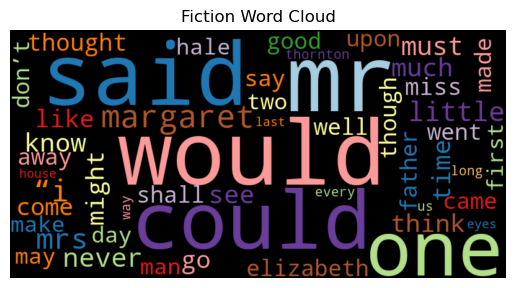

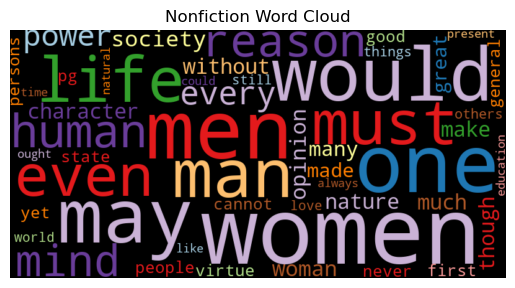

In [11]:
# Word clouds based on genre
# Function to count words
def count_words(df, column='Tokens', preprocess=None, min_freq=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    counter = Counter()
    df[column].map(update)

    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

# Count words for each genre
fiction_word_count = count_words(books[books['Genre'] == 'Fiction'], column='Tokens')
nonfiction_word_count = count_words(books[books['Genre'] == 'Nonfiction'], column='Tokens')

# Define the word cloud function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color="black", colormap="Paired",
                   max_font_size=150, max_words=max_words)
    
    # Convert data frame into dict
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    
    # Filter stop words in frequency counter
    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}
    
    wc.generate_from_frequencies(counter)
    
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Generate word clouds for each genre
wordcloud(fiction_word_count['freq'], title="Fiction Word Cloud", max_words=50, stopwords=None)
wordcloud(nonfiction_word_count['freq'], title="Nonfiction Word Cloud", max_words=50, stopwords=None)

One of the most notable differences in the two word clouds of the genres is the inclusion and the sizse of the word "said" in fiction corporas. This is expected in that of fiction novels as the novel is likely heavy in dialect between characters in order to tell a story.

Similary, the nonfiction wordcloud sees words like "reason" and "opinion" that would suggest more factual, informational text. The wordclouds provide an overview of a clear difference in the sentiment of the two genres, which will hopefully transpire within the classification and topic modeling.

## Text Classification

#### Fiction vs. Nonfiction

In [12]:
# Split text into sentences
books_expanded = books.assign(Text=books['Text'].apply(sent_tokenize)).explode('Text').reset_index(drop=True)

# Drop irrelevant columns
books_expanded = books_expanded.drop(columns=['Cleaned_Text', 'Tokens'])

# Remove rows where the Text column doesn't have at least 5 words
books_filtered = books_expanded[books_expanded['Text'].str.split().str.len() >= 5]

# Ensure books_filtered is a copy to avoid SettingWithCopyWarning
books_filtered = books_filtered.copy()

# Clean the text using a custom cleaning pipeline function
books_filtered['Cleaned_Text'] = books_filtered['Text'].apply(pipeline)

# Tokenize the cleaned text using a custom tokenization function
books_filtered['Tokens'] = books_filtered['Cleaned_Text'].apply(tokenize)

In [13]:
# Prepare data for modeling
# Prepare the features and labels
X = books_filtered['Cleaned_Text']  
y = books_filtered['Genre'] 

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF in prep for models
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Validate split
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  20610
Size of Test Data  5153


##### Base Model - Logistic Regression

In [14]:
# Initialize and train a classification model (Logistic Regression in this case)
model = LogisticRegression(random_state=123)
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_log = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_log))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

Accuracy: 0.9367358820104793
Confusion Matrix:
 [[4026   66]
 [ 260  801]]

Classification Report:
               precision    recall  f1-score   support

     Fiction       0.94      0.98      0.96      4092
  Nonfiction       0.92      0.75      0.83      1061

    accuracy                           0.94      5153
   macro avg       0.93      0.87      0.90      5153
weighted avg       0.94      0.94      0.93      5153



##### Naive Bayes

In [15]:
# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_nb)) 

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.9481855229963129
Confusion Matrix:
[[4009   83]
 [ 184  877]]

Classification Report:
              precision    recall  f1-score   support

     Fiction       0.96      0.98      0.97      4092
  Nonfiction       0.91      0.83      0.87      1061

    accuracy                           0.95      5153
   macro avg       0.93      0.90      0.92      5153
weighted avg       0.95      0.95      0.95      5153



## Topic Modeling

##### Non-Negative Factorization Model

In [16]:
# Topic modeling for two predefined topics - Fiction and Nonfiction

# Call on previous vectorizer
tfidf_text_vectors = tfidf.fit_transform(books_filtered['Cleaned_Text'])

# Create Display topics Function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

# NMF Topic Modeling
n_components = 2  # Fiction and Nonfiction
nmf_text_model = NMF(n_components=n_components, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

# Display the topics
display_topics(nmf_text_model, tfidf.get_feature_names_out())


Topic 00
 said (1.65)
 margaret (1.05)
 know (0.74)
 think (0.58)
 like (0.54)

Topic 01
 mr (7.45)
 thornton (3.25)
 mr thornton (2.76)
 hale (2.52)
 mr hale (1.92)


##### Latent Semantic Analysis

In [17]:
svd_text_model = TruncatedSVD(n_components = 2, random_state=123)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

# Map topics to genres
lsa_topic_to_category = defaultdict(list)
for idx, row in enumerate(W_svd_text_matrix):
    topic = np.where(row == np.amax(row))[0][0]  # Get the topic with the highest score
    category = books_filtered['Genre'].iloc[idx]  # Get the corresponding genre
    lsa_topic_to_category[topic].append(category)

# Display the number of documents for each topic and the most common categories
for topic, categories in lsa_topic_to_category.items():
    print(f"For topic {topic} we have {len(categories)} documents.")
    print(Counter(categories).most_common(5))
    print('\n') # add spacing for cleaner output

# Create Display topics Function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

# Display the top words for each topic
display_topics(svd_text_model, tfidf.get_feature_names_out())


For topic 0 we have 24794 documents.
[('Fiction', 19417), ('Nonfiction', 5377)]


For topic 1 we have 969 documents.
[('Fiction', 963), ('Nonfiction', 6)]



Topic 00
 said (1.35)
 mr (1.21)
 margaret (0.89)
 know (0.57)
 thornton (0.54)

Topic 01
 mr (11.10)
 thornton (4.65)
 mr thornton (4.23)
 hale (3.21)
 mr hale (2.76)
